In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primaldual_PINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

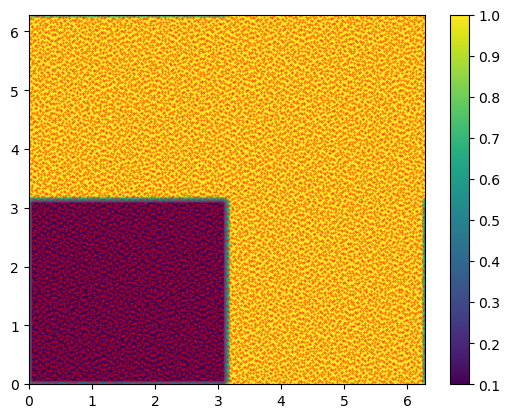

In [ ]:
L = 2*np.pi
N = 1024 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    eps = 2 * np.pi / 1e2
    x_dir = 0.5 * (np.clip(np.sin(x), -eps, eps) + eps) / eps
    y_dir = 0.5 * (np.clip(np.sin(y), -eps, eps) + eps) / eps
    a = 0.1 + 0.9*(1 - x_dir * y_dir)
    return a

def A_interp(x):  
    eps = 10
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x[:,0]))
    y_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x[:,1]))
    a = 1 - 0.9*x_dir*y_dir
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    eps = 10
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x[:,0]))
    y_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x[:,1]))
    a = 1 - 0.9*x_dir*y_dir
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

In [4]:
net = PINN_2(n_periodic=5, n_hidden=10, n_layers=2, period_len=L)
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/PINN_double/square/PINN_double_{total_params}'}

Number of parameters: 782


In [5]:
net = load_network(net, args['name']+'_29999', args)
net = net.to(dev)

In [9]:
losses_train, losses_val = train(net, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  3.58665497e+02, mean val. loss:  3.56444153e+02
Epoch: 1 mean train loss:  3.58553436e+02, mean val. loss:  3.56333069e+02
Epoch: 2 mean train loss:  3.58441254e+02, mean val. loss:  3.56221832e+02
Epoch: 3 mean train loss:  3.58328918e+02, mean val. loss:  3.56110504e+02
Epoch: 4 mean train loss:  3.58216492e+02, mean val. loss:  3.55998962e+02
Epoch: 5 mean train loss:  3.58103851e+02, mean val. loss:  3.55887299e+02
Epoch: 6 mean train loss:  3.57991119e+02, mean val. loss:  3.55775452e+02
Epoch: 7 mean train loss:  3.57878204e+02, mean val. loss:  3.55663391e+02
Epoch: 8 mean train loss:  3.57765076e+02, mean val. loss:  3.55551056e+02
Epoch: 9 mean train loss:  3.57651611e+02, mean val. loss:  3.55438477e+02
Epoch: 10 mean train loss:  3.57538025e+02, mean val. loss:  3.55325714e+02
Epoch: 11 mean train loss:  3.57424103e+02, mean val. loss:  3.55212585e+02
Epoch: 12 mean train loss:  3.57309967e+02, mean val. loss:  3.55099152e+02
Epoch: 13 mean train l

In [11]:
np.save(f'NN_library/training_data/square/PINN_double_{total_params}', np.vstack([losses_train, losses_val]))

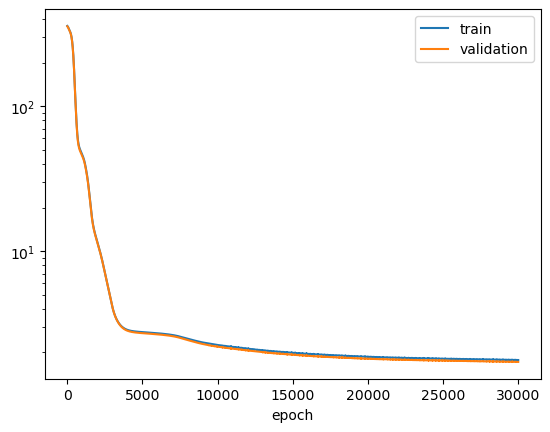

In [10]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [12]:
U = net(grid_data).detach().cpu()
pde_p, pde_d, _, _ = PDE_loss_primal_dual(grid_data, net, A, H1)

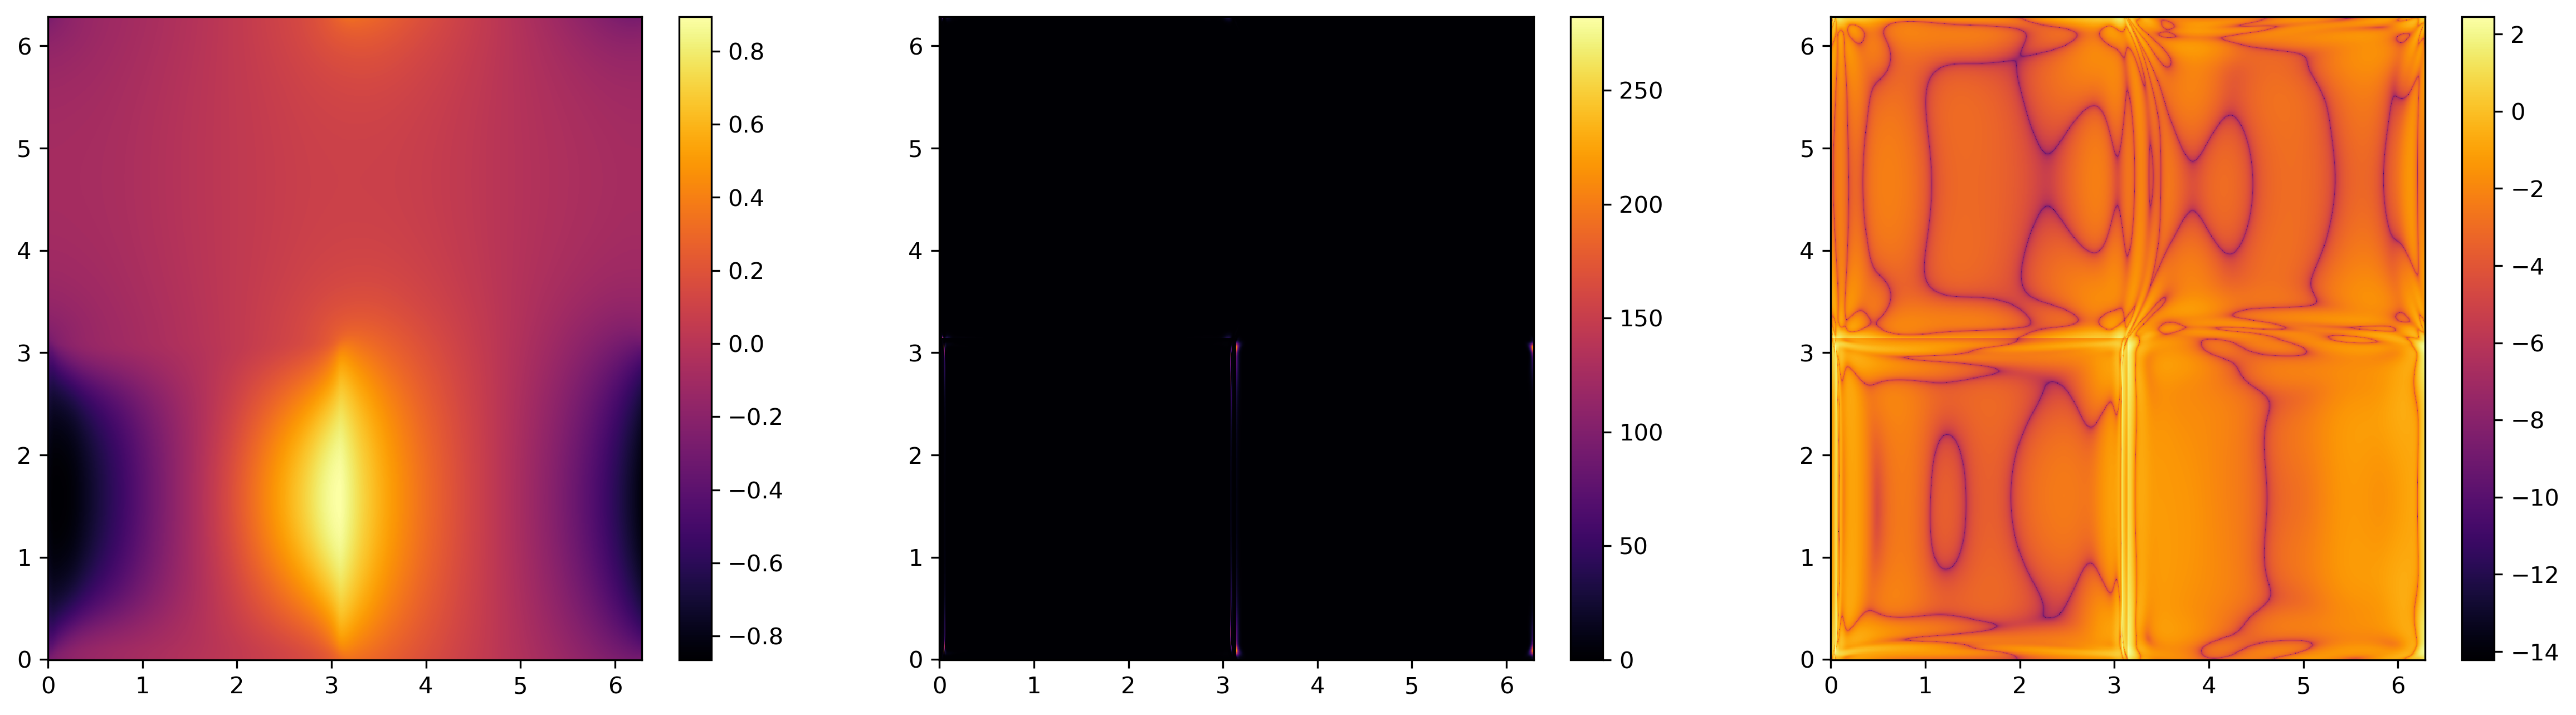

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,0].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], pde_p.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(pde_p.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

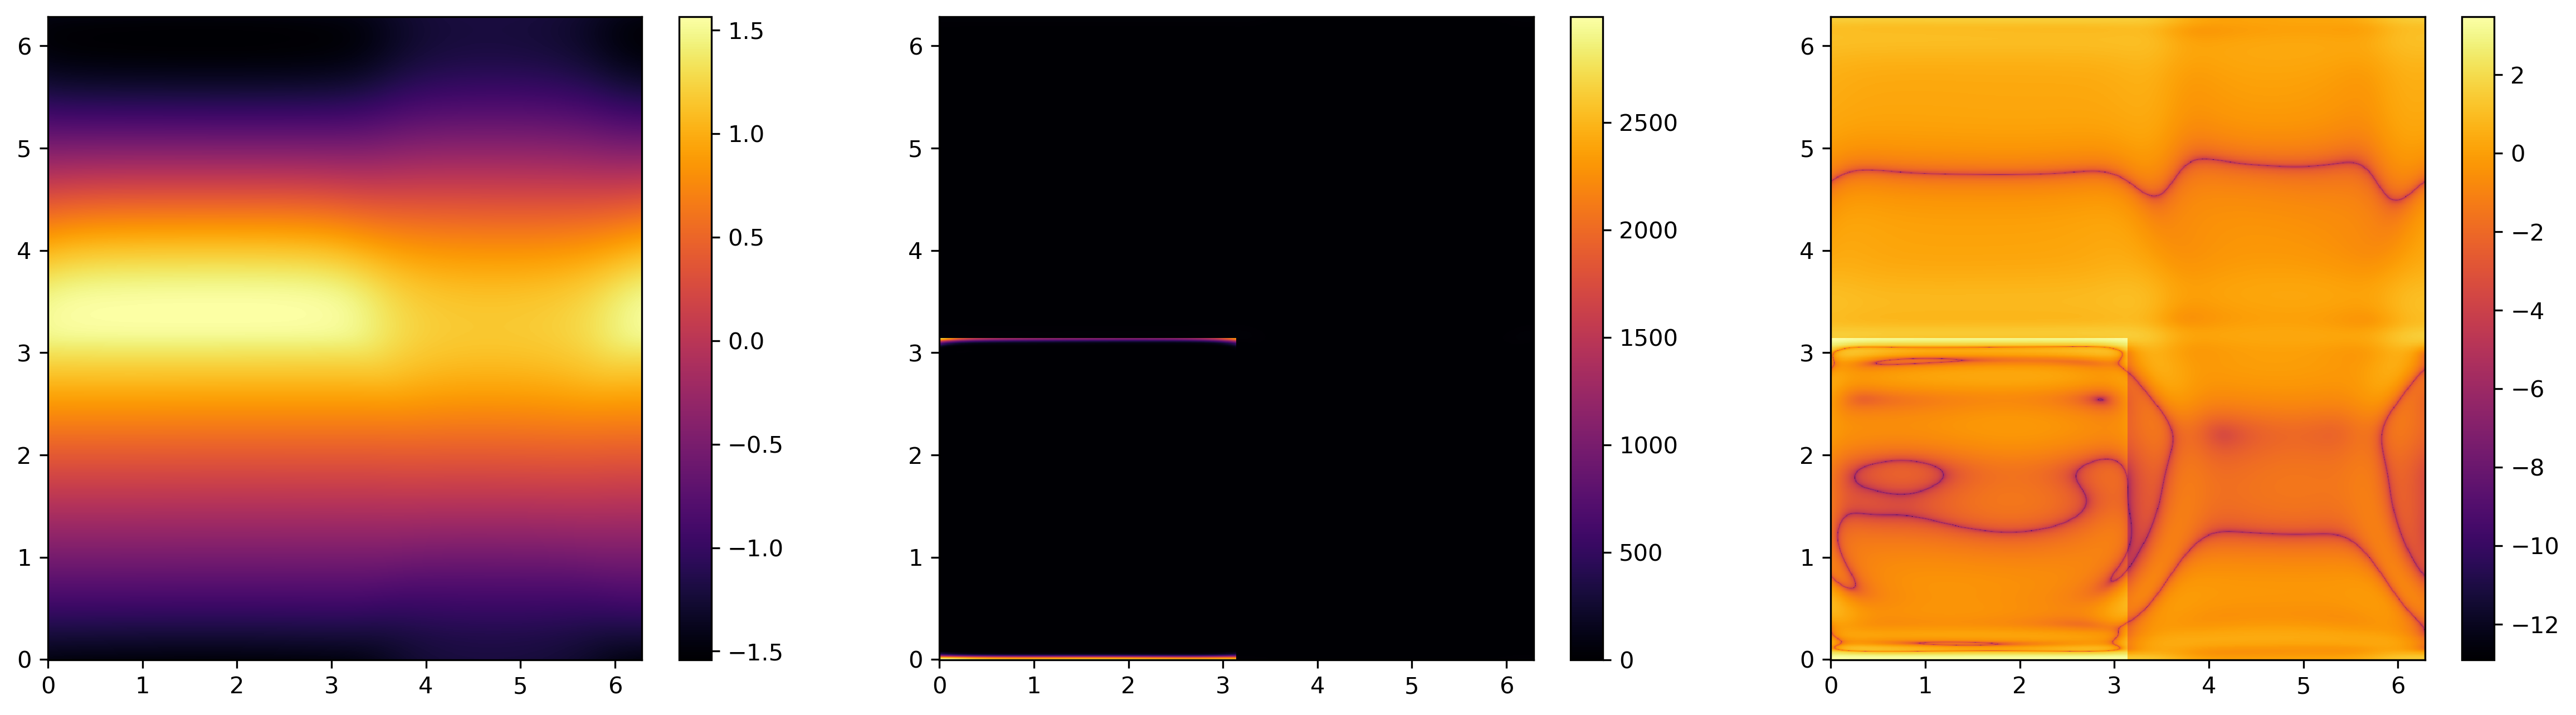

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,1].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], pde_d.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(pde_d.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [6]:
inputs = data[:].to(dev).requires_grad_(True)
T = net(inputs)
dq1 = torch.autograd.grad(
            outputs=T[:,0], inputs=inputs,
            grad_outputs=torch.ones_like(T[:,0]),
            create_graph=True, retain_graph=True
    )[0].detach()
dq2 = torch.autograd.grad(
            outputs=T[:,1], inputs=inputs,
            grad_outputs=torch.ones_like(T[:,1]),
            create_graph=True, retain_graph=True
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
curl = torch.zeros_like(dq2)
curl[:,0] = -dq2[:,1]
curl[:,1] = dq2[:,0]

In [16]:
A_bound = compute_bound(T[:,0], dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[6.76310244e-01]
 [3.69977490e-05]]
[[0.64535332]
 [0.00845302]]


In [17]:
np.save(f'bounds/square/A_u_PINN_double_{total_params}.npy', (A_bound[0][0], A_bound[1][0]))

In [7]:
B_bound = compute_bound(T[:,1], curl, triang, inputs, A_inv, H1, L, 'dual')
print(B_bound[0])
print(B_bound[1])

[[0.86982594 0.00093391]
 [0.00093391 0.86982594]]
[[ 0.87583996 -0.03627487]
 [-0.03627487  0.87583996]]


In [8]:
np.save(f'bounds/square/A_l_PINN_double_{total_params}.npy', (B_bound[0][0], B_bound[1][0]))